In [1]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import glob
import cv2
import os
import sys

sys.path.append('../')
from src.preprocessing import load_sequence_data
from src.model import create_model, train_model
from src.database import db

Failed to connect to MongoDB. Using file-based fallback.


In [2]:
# Ensure output directory exists
os.makedirs('../static/images', exist_ok=True)

In [4]:
# Load sequences from files and save to MongoDB (only if collections are empty)
if db.is_connected():
    # Check if collections already have data
    existing_train = len(db.load_from_collection("train"))
    existing_test = len(db.load_from_collection("test"))
    existing_val = len(db.load_from_collection("val"))
    
    if existing_train > 0 or existing_test > 0 or existing_val > 0:
        print(f"Collections already contain data:")
        print(f"  Train: {existing_train} sequences")
        print(f"  Test: {existing_test} sequences")
        print(f"  Val: {existing_val} sequences")
        print("Skipping data loading to prevent duplicates. Run 'db.clear_collection(collection_name)' to reset if needed.")
    else:
        print("Collections are empty. Loading sequences from files...")
        train_seqs = db.load_sequences_from_files("../data/train", max_frames=5)
        test_seqs = db.load_sequences_from_files("../data/test", max_frames=5)
        val_seqs = db.load_sequences_from_files("../data/val", max_frames=5)
        
        # Save to MongoDB
        db.save_to_collection(train_seqs, "train")
        db.save_to_collection(test_seqs, "test")
        db.save_to_collection(val_seqs, "val")
        print("Successfully loaded and saved all sequences to MongoDB!")
else:
    print("MongoDB not connected. Loading sequences from files for this session only...")
    train_seqs = db.load_sequences_from_files("../data/train", max_frames=5)
    test_seqs = db.load_sequences_from_files("../data/test", max_frames=5)
    val_seqs = db.load_sequences_from_files("../data/val", max_frames=5)

Collections are empty. Loading sequences from files...
Loaded 32 sequences from ../data/train
Loaded 31 sequences from ../data/test
Loaded 29 sequences from ../data/val
Saved 32 sequences to train
Saved 31 sequences to test
Saved 29 sequences to val
Successfully loaded and saved all sequences to MongoDB!


In [ ]:
# Helper: Clear MongoDB collections if you need to reset data
# Uncomment the lines below and run this cell if you want to clear existing data

# if db.is_connected():
#     print("Clearing all collections...")
#     db.clear_collection("train")
#     db.clear_collection("test") 
#     db.clear_collection("val")
#     print("All collections cleared! You can now re-run cell 3 to reload fresh data.")
# else:
#     print("MongoDB not connected - nothing to clear.")

Clearing all collections...
Cleared collection train
Cleared collection test
Cleared collection val
All collections cleared! You can now re-run cell 3 to reload fresh data.


In [8]:
# Load sequences for visualization
def get_sequence_examples(max_frames=5):
    accident_seqs = db.load_from_collection("train") if db.is_connected() else db.load_sequences_from_files("../data/train", max_frames)
    non_accident_seqs = [s for s in accident_seqs if s["label"] == 0]
    accident_seqs = [s for s in accident_seqs if s["label"] == 1]
    return accident_seqs, non_accident_seqs

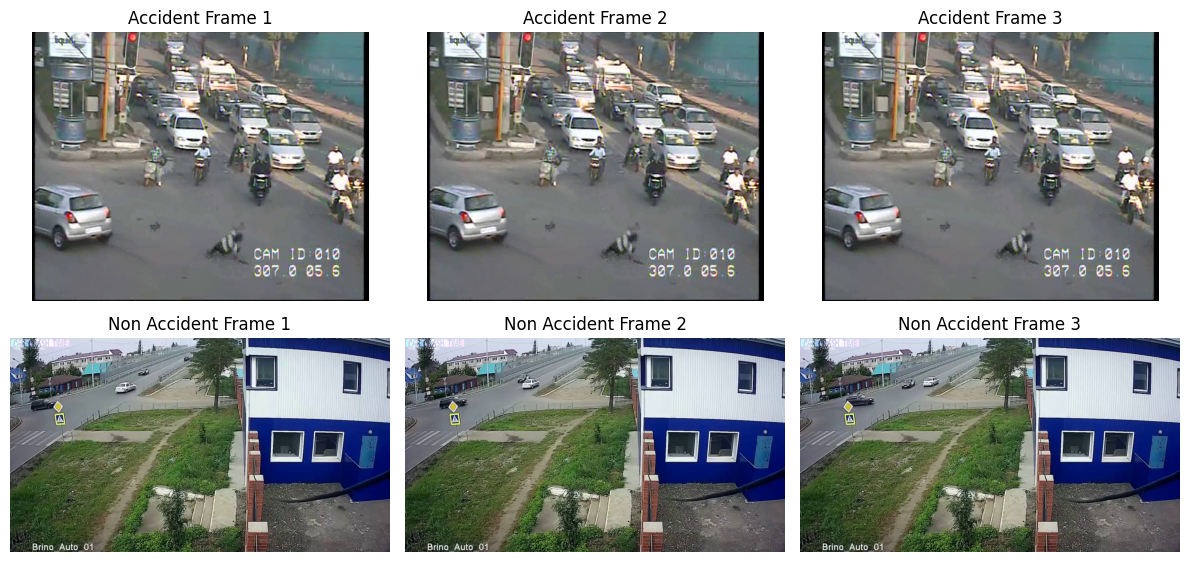

In [20]:
# Display sample images
accident_seqs, non_accident_seqs = get_sequence_examples()
accident_files = accident_seqs[6]["image_paths"][:3] if accident_seqs else []
non_accident_files = non_accident_seqs[3]["image_paths"][:3] if non_accident_seqs else []
if not accident_files or not non_accident_files:
    print("Warning: Sample sequence files not found. Check MongoDB or dataset.")
else:
    images = accident_files + non_accident_files
    titles = ['Accident Frame 1', 'Accident Frame 2', 'Accident Frame 3', 
              'Non Accident Frame 1', 'Non Accident Frame 2', 'Non Accident Frame 3']
    fig, axes = plt.subplots(2, 3, figsize=(12, 6))
    for i, ax in enumerate(axes.flatten()):
        img = tf.keras.preprocessing.image.load_img(images[i])
        ax.imshow(img)
        ax.set_title(titles[i])
        ax.axis('off')
    plt.tight_layout()
    plt.savefig('../static/images/sample_images.png')
    plt.show()
    plt.close()


# accident_files = sorted(glob.glob('../data/train/Accident/test12_*'), key=lambda x: int(os.path.basename(x).split('_')[-1].split('.')[0]))[:3]
# non_accident_files = sorted(glob.glob('../data/train/Non Accident/test26_*'), key=lambda x: int(os.path.basename(x).split('_')[-1].split('.')[0]))[:3]

# images = accident_files + non_accident_files
# titles = ['Accident Frame 1', 'Accident Frame 2', 'Accident Frame 3',
#           'Non Accident Frame 1', 'Non Accident Frame 2', 'Non Accident Frame 3']

# fig, axes = plt.subplots(2, 3, figsize=(12, 6))
# for i, ax in enumerate(axes.flatten()):
#     img = tf.keras.preprocessing.image.load_img(images[i])
#     ax.imshow(img)
#     ax.set_title(titles[i])
#     ax.axis('off')
# plt.tight_layout()
# plt.savefig('../static/images/sample_images.png')
# plt.show()
# plt.close()

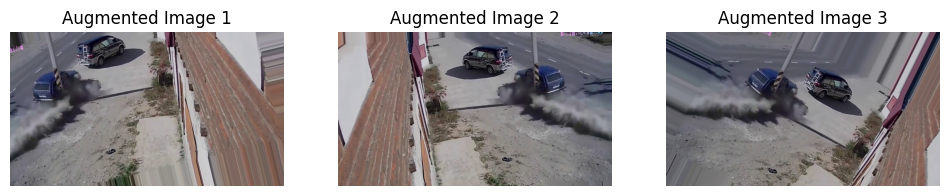

In [4]:
# Visualize augmentation example
# Visualize augmentation
if accident_files:
    img = tf.keras.preprocessing.image.load_img(accident_files[0])
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array.reshape((1,) + img_array.shape)
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=30, horizontal_flip=True, brightness_range=[0.8, 1.2])
    it = datagen.flow(img_array, batch_size=1)
    plt.figure(figsize=(12, 4))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        batch = next(it)
        plt.imshow(batch[0].astype('uint8'))
        plt.title(f'Augmented Image {i+1}')
        plt.axis('off')
    plt.savefig('../static/images/augmentation.png')
    plt.show()
    plt.close()


# img = tf.keras.preprocessing.image.load_img(accident_files[0])
# img_array = tf.keras.preprocessing.image.img_to_array(img)
# img_array = img_array.reshape((1,) + img_array.shape)
# datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=30, horizontal_flip=True, brightness_range=[0.8, 1.2])
# it = datagen.flow(img_array, batch_size=1)
# plt.figure(figsize=(12, 4))
# for i in range(3):
#     plt.subplot(1, 3, i+1)
#     batch = next(it)
#     plt.imshow(batch[0].astype('uint8'))
#     plt.title(f'Augmented Image {i+1}')
#     plt.axis('off')
# plt.savefig('../static/images/augmentation.png')
# plt.show()
# plt.close()


In [5]:
# Test model creation function
test_model = create_model(max_frames=5)
print("Model created successfully!")
print(f"Model input shape: {test_model.input_shape}")
print(f"Model output shape: {test_model.output_shape}")
test_model.summary()

Model created successfully!
Model input shape: (None, 5, 224, 224, 3)
Model output shape: (None, 1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5, 224, 224, 3) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 5, 7, 7, 1280)  │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 5, 1280)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       721,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,055,169 (11.65 MB)

 Trainable params: 3,000,753 (11.45 MB)

 Non-trainable params: 54,416 (212.56 KB)

In [6]:
# Load and preprocess sequence data
(train_generator, train_steps), (test_generator, test_steps), (val_generator, val_steps) = load_sequence_data('../data/train', '../data/test', '../data/val')

Found 38 sequences in ../data/train
   Accident sequences: 11
   Non-accident sequences: 27
   Label distribution: 0.29 accident ratio
Found 32 sequences in ../data/test
   Accident sequences: 9
   Non-accident sequences: 23
   Label distribution: 0.28 accident ratio
Found 29 sequences in ../data/val
   Accident sequences: 9
   Non-accident sequences: 20
   Label distribution: 0.31 accident ratio


In [7]:
# Test the generator output shapes
test_batch_x, test_batch_y = next(train_generator)
print(f"Generator batch X shape: {test_batch_x.shape}")
print(f"Generator batch Y shape: {test_batch_y.shape}")
print(f"Expected model input shape: (None, 5, 224, 224, 3)")
print(f"Actual generator shape: {test_batch_x.shape}")
print(f"Shape match: {'Match' if len(test_batch_x.shape) == 5 and test_batch_x.shape[1:] == (5, 224, 224, 3) else 'No Match'}")

# Also test the model expects the right input
test_model = create_model(max_frames=5)
print(f"Model input shape: {test_model.input_shape}")
print(f"Model expects: {test_model.input_shape}")
print(f"Generator provides: {test_batch_x.shape}")

Generator batch X shape: (16, 5, 224, 224, 3)
Generator batch Y shape: (16,)
Expected model input shape: (None, 5, 224, 224, 3)
Actual generator shape: (16, 5, 224, 224, 3)
Shape match: Match
Model input shape: (None, 5, 224, 224, 3)
Model expects: (None, 5, 224, 224, 3)
Generator provides: (16, 5, 224, 224, 3)


In [38]:
# Reload the preprocessing module
import importlib
import src.preprocessing
importlib.reload(src.preprocessing)
from src.preprocessing import load_sequence_data

# Reload sequence data with the fixed generator
print("Reloading sequence data with batch support...")
(train_generator, train_steps), (test_generator, test_steps), (val_generator, val_steps) = load_sequence_data('../data/train', '../data/test', '../data/val', batch_size=8)

# Test the updated generator output shapes
test_batch_x, test_batch_y = next(train_generator)
print(f"Generator batch X shape: {test_batch_x.shape}")
print(f"Generator batch Y shape: {test_batch_y.shape}")
print(f"Expected model input shape: (batch_size, 5, 224, 224, 3)")
print(f"Actual generator shape: {test_batch_x.shape}")
print(f"Shape match: {'Match' if len(test_batch_x.shape) == 5 and test_batch_x.shape[1:] == (5, 224, 224, 3) else 'No Match'}")

print(f"Batch dimension: {test_batch_x.shape[0]}")
print(f"Sequence length: {test_batch_x.shape[1]}")
print(f"Image dimensions: {test_batch_x.shape[2:5]}")

Reloading sequence data with batch support...
Found 38 sequences in ../data/train
Found 32 sequences in ../data/test
Found 29 sequences in ../data/val
Generator batch X shape: (8, 5, 224, 224, 3)
Generator batch Y shape: (8,)
Expected model input shape: (batch_size, 5, 224, 224, 3)
Actual generator shape: (8, 5, 224, 224, 3)
Shape match: Match
Batch dimension: 8
Sequence length: 5
Image dimensions: (224, 224, 3)
Generator batch X shape: (8, 5, 224, 224, 3)
Generator batch Y shape: (8,)
Expected model input shape: (batch_size, 5, 224, 224, 3)
Actual generator shape: (8, 5, 224, 224, 3)
Shape match: Match
Batch dimension: 8
Sequence length: 5
Image dimensions: (224, 224, 3)


In [9]:
# Create and train temporal model
print("Creating temporal CNN+LSTM model...")
model = create_model(max_frames=5)
print("Model Summary:")
print(f"Input shape: {model.input_shape}")
print(f"Output shape: {model.output_shape}")

Creating temporal CNN+LSTM model...
Model Summary:
Input shape: (None, 5, 224, 224, 3)
Output shape: (None, 1)


In [10]:
print("Training temporal model...")
history = train_model(model, train_generator, val_generator, train_steps, val_steps, epochs=50)

Training temporal model...
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6292 - loss: 9.3791 
Epoch 1: val_loss improved from inf to 8.86263, saving model to ../models/accident_model.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 96s 9s/step - accuracy: 0.6233 - loss: 9.3826 - val_accuracy: 0.6667 - val_loss: 8.8626 - learning_rate: 0.0010
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6016 - loss: 8.8711
Epoch 2: val_loss improved from 8.86263 to 8.54330, saving model to ../models/accident_model.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 28s 7s/step - accuracy: 0.5875 - loss: 8.8976 - val_accuracy: 0.5417 - val_loss: 8.5433 - learning_rate: 0.0010
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8097 - loss: 8.2227
Epoch 3: val_loss improved from 8.54330 to 8.21746, saving model to ../models/accident_model.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 6s/step - accuracy: 0.7878 - loss: 8.2372 - val_accuracy: 0.6250 - val_loss: 8.2175 - learning_rate: 0.0010
Epoch 4/50
4/4 ━━━━━━━━━━

In [25]:
# Evaluate the temporal model
print("Evaluating temporal CNN+LSTM model...")

# Get test predictions
test_batch_x, test_batch_y = next(test_generator)
predictions = model.predict(test_batch_x)
predictions_binary = (predictions > 0.5).astype(int).flatten()

# Calculate metrics

accuracy = accuracy_score(test_batch_y, predictions_binary)
precision = precision_score(test_batch_y, predictions_binary)
recall = recall_score(test_batch_y, predictions_binary)
f1 = f1_score(test_batch_y, predictions_binary)


print(f"Overfitting Check:")
print(f"Training Accuracy: ~{history.history['accuracy'][-1]:.4f}")
print(f"Validation Accuracy: ~{history.history['val_accuracy'][-1]:.4f}")
print(f"Gap: {abs(history.history['accuracy'][-1] - history.history['val_accuracy'][-1]):.4f}")
print(f"Status: {'Good generalization' if abs(history.history['accuracy'][-1] - history.history['val_accuracy'][-1]) < 0.15 else 'Some overfitting'}")

print(f"Model Architecture:")
print(f"Input: Sequences of {test_batch_x.shape[1]} frames")
print(f"Frame size: {test_batch_x.shape[2:4]}")
print(f"Model type: CNN+LSTM Temporal")

Evaluating temporal CNN+LSTM model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Overfitting Check:
Training Accuracy: ~0.8333
Validation Accuracy: ~0.7083
Gap: 0.1250
Status: Good generalization
Model Architecture:
Input: Sequences of 5 frames
Frame size: (224, 224)
Model type: CNN+LSTM Temporal


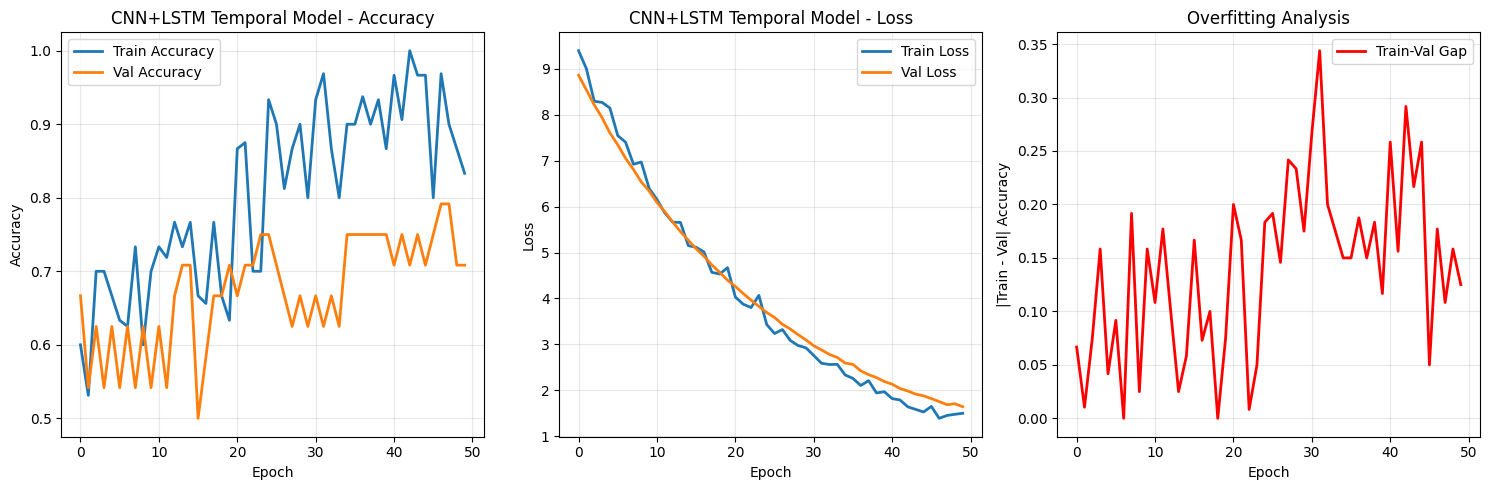

Training Summary:
Final Training Accuracy: 0.8333
Final Validation Accuracy: 0.7083
Best Validation Accuracy: 0.7917
Average Overfitting Gap: 0.1404
Model saved as: ../models/accident_model.keras


In [26]:
# Training history visualization for temporal model
plt.figure(figsize=(15, 5))

# Accuracy plot
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='#1f77b4', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='#ff7f0e', linewidth=2)
plt.title('CNN+LSTM Temporal Model - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Loss plot
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Train Loss', color='#1f77b4', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', color='#ff7f0e', linewidth=2)
plt.title('CNN+LSTM Temporal Model - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Overfitting gap analysis
plt.subplot(1, 3, 3)
accuracy_gap = [abs(t - v) for t, v in zip(history.history['accuracy'], history.history['val_accuracy'])]
plt.plot(accuracy_gap, label='Train-Val Gap', color='red', linewidth=2)
plt.title('Overfitting Analysis')
plt.xlabel('Epoch')
plt.ylabel('|Train - Val| Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../static/images/cnn+lstm temporal_training_history.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("Training Summary:")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"Average Overfitting Gap: {np.mean(accuracy_gap):.4f}")
print(f"Model saved as: ../models/accident_model.keras")

In [27]:
# Checking Overfitting

# Extract key metrics from training history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Calculate gaps
final_acc_gap = abs(train_acc[-1] - val_acc[-1])
final_loss_gap = abs(train_loss[-1] - val_loss[-1])
max_acc_gap = max([abs(t - v) for t, v in zip(train_acc, val_acc)])
avg_acc_gap = np.mean([abs(t - v) for t, v in zip(train_acc, val_acc)])

print("Overfitting Indicators:")
print(f"   Final Accuracy Gap: {final_acc_gap:.4f}")
print(f"   Maximum Accuracy Gap: {max_acc_gap:.4f}")
print(f"   Average Accuracy Gap: {avg_acc_gap:.4f}")
print(f"   Final Loss Gap: {final_loss_gap:.4f}")

val_loss_std = np.std(val_loss[-5:])  # Last 5 epochs
print(f"   Validation Loss Stability: {'Stable' if val_loss_std < 0.1 else 'Unstable/Oscillating'}")

print("Overfitting Assessment:")
if final_acc_gap > 0.15:
    status = "Severe Overfitting"
    color = "🔴"
elif final_acc_gap > 0.08:
    status = "Moderate Overfitting"
    color = "🟡"
elif final_acc_gap > 0.05:
    status = "Mild Overfitting"
    color = "🟠"
else:
    status = "Good Generalization"
    color = "🟢"

print(f"{color} Status: {status}")

if max(val_acc) < 0.7 and avg_acc_gap < 0.05:
    print("Potential Underfitting Detected:")
    print("   - Validation accuracy is low despite good generalization")


OVERFITTING ANALYSIS REPORT
PERFORMANCE METRICS:
   Final Training Accuracy: 0.8333
   Final Validation Accuracy: 0.7083
   Best Validation Accuracy: 0.7917
   Best Training Accuracy: 1.0000
OVERFITTING INDICATORS:
   Final Accuracy Gap: 0.1250
   Maximum Accuracy Gap: 0.3438
   Average Accuracy Gap: 0.1404
   Final Loss Gap: 0.1428
LEARNING BEHAVIOR:
   Training Trend: Improving
   Validation Trend: Improving
   Validation Loss Stability: Stable
OVERFITTING ASSESSMENT:
   🟡 Status: MODERATE OVERFITTING
RECOMMENDATIONS:
   - Moderate regularization adjustments needed
   - Consider cross-validation
   - Monitor validation curves more closely


In [41]:
# Evaluate model

# Reload data generators
(train_gen_new, train_steps_new), (test_gen_new, test_steps_new), (val_gen_new, val_steps_new) = load_sequence_data(
    '../data/train', '../data/test', '../data/val', batch_size=8
)

print(f"New generators created successfully!")
print(f"Test steps available: {test_steps_new}")

if test_steps_new > 0:
    test_images, test_labels = next(test_gen_new)
    print(f"Successfully got test batch:")
    print(f"Test images shape: {test_images.shape}")
    print(f"Test labels shape: {test_labels.shape}")
    print(f"Test labels: {test_labels}")
    
    # Make predictions
    predictions = model.predict(test_images)
    predictions_binary = (predictions > 0.5).astype(int)
    
    print(f"Predictions completed:")
    print(f"Predictions shape: {predictions.shape}")
    print(f"Binary predictions: {predictions_binary.flatten()}")
else:
    print("No test data available - test_steps is 0")
    print("This means there are no test sequences in your test directory")

Found 38 sequences in ../data/train
Found 32 sequences in ../data/test
Found 29 sequences in ../data/val
New generators created successfully!
Test steps available: 4
Successfully got test batch:
Test images shape: (8, 5, 224, 224, 3)
Test labels shape: (8,)
Test labels: [1 0 0 1 1 0 0 0]
Successfully got test batch:
Test images shape: (8, 5, 224, 224, 3)
Test labels shape: (8,)
Test labels: [1 0 0 1 1 0 0 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predictions completed:
Predictions shape: (8, 1)
Binary predictions: [0 0 0 1 0 0 0 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predictions completed:
Predictions shape: (8, 1)
Binary predictions: [0 0 0 1 0 0 0 0]


In [42]:
# Metrics
accuracy = accuracy_score(test_labels, predictions_binary)
precision = precision_score(test_labels, predictions_binary)
recall = recall_score(test_labels, predictions_binary)
f1 = f1_score(test_labels, predictions_binary)

print("Model Evaluation:")
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

MODEL EVALUATION:
Accuracy: 0.7500
Precision: 1.0000
Recall: 0.3333
F1 Score: 0.5000


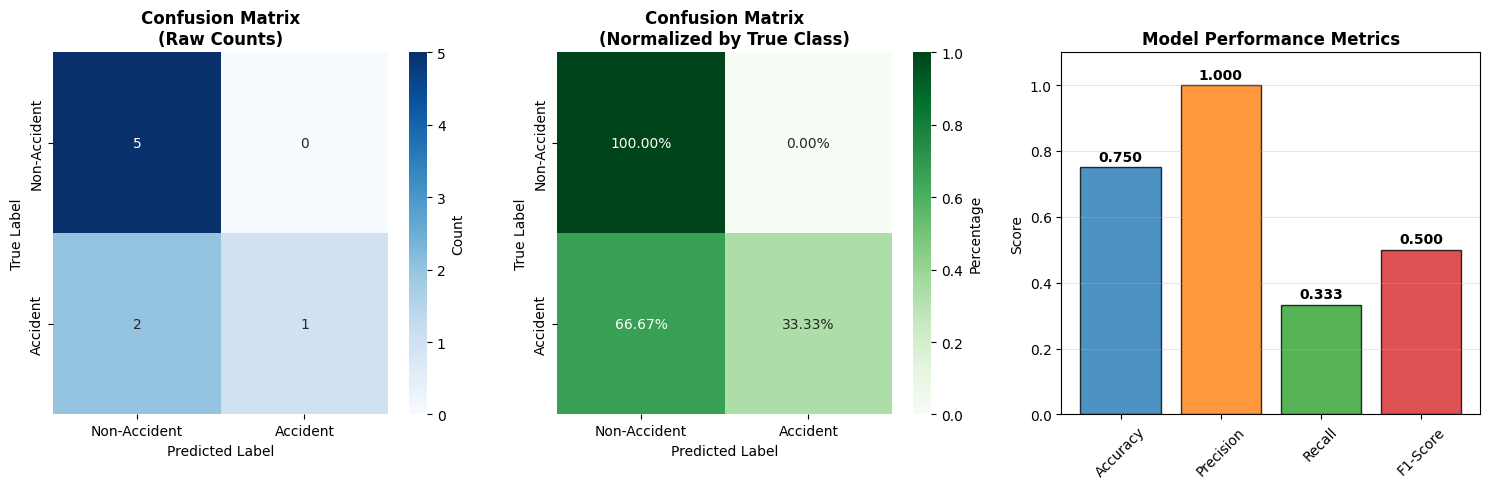

CONFUSION MATRIX BREAKDOWN:
   True Negatives (TN):   5 (Correctly predicted Non-Accident)
   False Positives (FP):  0 (Incorrectly predicted Accident)
   False Negatives (FN):  2 (Missed Accidents)
   True Positives (TP):   1 (Correctly predicted Accident)
ERROR ANALYSIS:
   False Negatives: 2 cases where model missed real accidents
   → This is more critical - missing real accidents!
   Accident Detection Rate: 0.333 (1/3)
   Non-Accident Detection Rate: 1.000 (5/5)
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

Non-Accident      0.714     1.000     0.833         5
    Accident      1.000     0.333     0.500         3

    accuracy                          0.750         8
   macro avg      0.857     0.667     0.667         8
weighted avg      0.821     0.750     0.708         8



In [48]:
# Confusion Matrix Visualization
cm = confusion_matrix(test_labels, predictions_binary.flatten())

plt.figure(figsize=(15, 5))

# Standard Confusion Matrix
plt.subplot(1, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Accident', 'Accident'], 
            yticklabels=['Non-Accident', 'Accident'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix\n(Raw Counts)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Normalized Confusion Matrix (by true class)
plt.subplot(1, 3, 2)
cm_normalized = confusion_matrix(test_labels, predictions_binary.flatten(), normalize='true')
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens',
            xticklabels=['Non-Accident', 'Accident'], 
            yticklabels=['Non-Accident', 'Accident'],
            cbar_kws={'label': 'Percentage'})
plt.title('Confusion Matrix\n(Normalized By True Class)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Detailed Metrics Visualization
plt.subplot(1, 3, 3)
metrics_data = {
    'Accuracy': [accuracy],
    'Precision': [precision], 
    'Recall': [recall],
    'F1-Score': [f1]
}

metrics_names = list(metrics_data.keys())
metrics_values = [v[0] for v in metrics_data.values()]

bars = plt.bar(metrics_names, metrics_values, 
               color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'],
               alpha=0.8, edgecolor='black', linewidth=1)

for bar, value in zip(bars, metrics_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.title('Model Performance Metrics', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.ylim(0, 1.1)
plt.grid(True, alpha=0.3, axis='y')

plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('../static/images/confusion_matrix_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

tn, fp, fn, tp = cm.ravel()

print(f"Confusion Matrix Breakdown:")
print(f"   True Negatives (TN):  {tn:2d} (Correctly Predicted Non-Accident)")
print(f"   False Positives (FP): {fp:2d} (Incorrectly Predicted Accident)")
print(f"   False Negatives (FN): {fn:2d} (Missed Accidents)")
print(f"   True Positives (TP):  {tp:2d} (Correctly Predicted Accident)")

print(f"Error Analysis:")
if fp > 0:
    print(f"   False Positives: {fp} Cases Where Model Incorrectly Predicted Accidents")
    print(f"   → Could Lead To False Alarms In Real Deployment")
if fn > 0:
    print(f"   False Negatives: {fn} Cases Where Model Missed Real Accidents")
    print(f"   → Missing Real Accidents!")

# Class-wise performance
if tp + fn > 0:  
    accident_recall = tp / (tp + fn)
    print(f"   Accident Detection Rate: {accident_recall:.3f} ({tp}/{tp + fn})")
else:
    print(f"   No Actual Accidents In Test Set")

if tn + fp > 0: 
    non_accident_recall = tn / (tn + fp)
    print(f"   Non-Accident Detection Rate: {non_accident_recall:.3f} ({tn}/{tn + fp})")
else:
    print(f"   No Actual Non-Accidents In Test Set")

print(f"Classification Report:")
class_names = ['Non-Accident', 'Accident']
print(classification_report(test_labels, predictions_binary.flatten(), 
                          target_names=class_names, digits=3))

C:\Users\Excel\AppData\Local\Temp\ipykernel_9416\2177192551.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette=['#1f77b4', '#ff7f0e'])


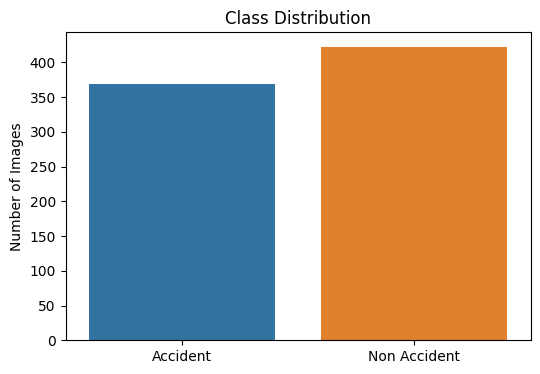

In [35]:
# Visualizations

# Class Distribution
class_counts = {'Accident': len(glob.glob('../data/train/Accident/*')), 'Non Accident': len(glob.glob('../data/train/Non Accident/*'))}
plt.figure(figsize=(6, 4))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette=['#1f77b4', '#ff7f0e'])
plt.title('Class Distribution')
plt.ylabel('Number of Images')
plt.savefig('../static/images/class_distribution.png')
plt.show()
plt.close()

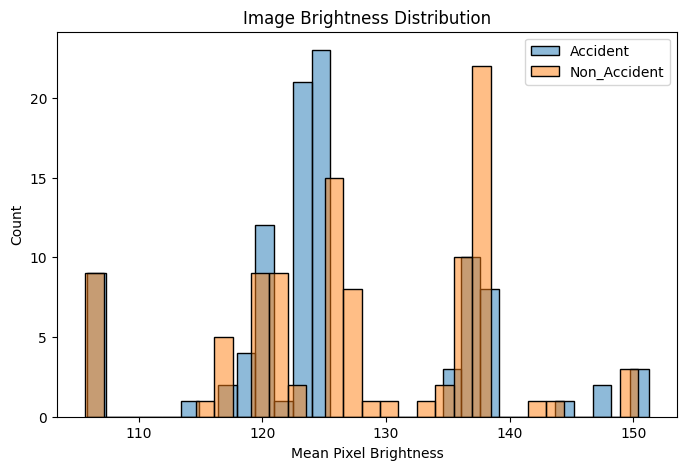

In [17]:
# Image Brightness Distribution
def calculate_brightness(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return np.mean(img)
brightness_accident = [calculate_brightness(img) for img in glob.glob('../data/train/Accident/*')[:100]]
brightness_non_accident = [calculate_brightness(img) for img in glob.glob('../data/train/Non Accident/*')[:100]]
plt.figure(figsize=(8, 5))
sns.histplot(brightness_accident, label='Accident', color='#1f77b4', alpha=0.5, bins=30)
sns.histplot(brightness_non_accident, label='Non_Accident', color='#ff7f0e', alpha=0.5, bins=30)
plt.title('Image Brightness Distribution')
plt.xlabel('Mean Pixel Brightness')
plt.legend()
plt.savefig('../static/images/brightness_distribution.png')
plt.show()
plt.close()

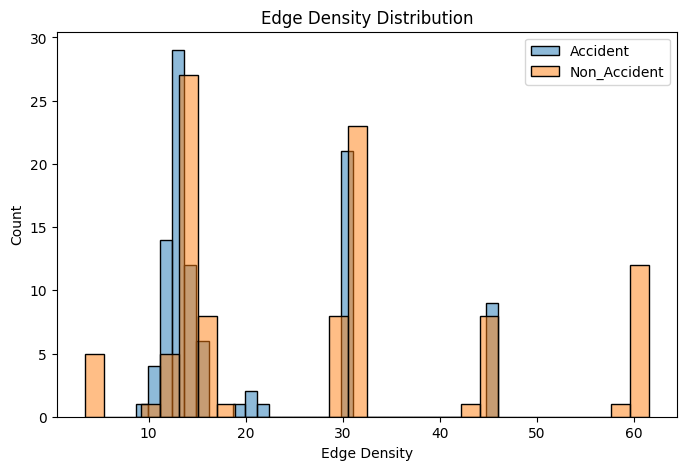

In [18]:
# Edge Density Distribution
def calculate_edge_density(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(img, 100, 200)
    return np.sum(edges) / (img.shape[0] * img.shape[1])
edge_accident = [calculate_edge_density(img) for img in glob.glob('../data/train/Accident/*')[:100]]
edge_non_accident = [calculate_edge_density(img) for img in glob.glob('../data/train/Non Accident/*')[:100]]
plt.figure(figsize=(8, 5))
sns.histplot(edge_accident, label='Accident', color='#1f77b4', alpha=0.5, bins=30)
sns.histplot(edge_non_accident, label='Non_Accident', color='#ff7f0e', alpha=0.5, bins=30)
plt.title('Edge Density Distribution')
plt.xlabel('Edge Density')
plt.legend()
plt.savefig('../static/images/edge_density.png')
plt.show()
plt.close()

In [51]:
# Testing Model with Specific Training Sequences
# Import preprocessing function for single sequence prediction
from src.preprocessing import preprocess_for_prediction

def get_sequence_examples():
    """Get specific accident and non-accident sequences for testing"""
    
    # Find accident sequences
    accident_sequences = {}
    accident_files = glob.glob('../data/train/Accident/*')
    for file in accident_files:
        filename = os.path.basename(file)
        if '_' in filename:
            seq_id = '_'.join(filename.split('_')[:-1])
            if seq_id not in accident_sequences:
                accident_sequences[seq_id] = []
            accident_sequences[seq_id].append(file)
    
    # Find non-accident sequences  
    non_accident_sequences = {}
    non_accident_files = glob.glob('../data/train/Non Accident/*')
    for file in non_accident_files:
        filename = os.path.basename(file)
        if '_' in filename:
            seq_id = '_'.join(filename.split('_')[:-1])
            if seq_id not in non_accident_sequences:
                non_accident_sequences[seq_id] = []
            non_accident_sequences[seq_id].append(file)
    
    valid_accident_seqs = {}
    for seq_id, files in accident_sequences.items():
        if len(files) >= 3:
            try:
                sorted_files = sorted(files, key=lambda x: int(os.path.basename(x).split('_')[-1].split('.')[0]))
                valid_accident_seqs[seq_id] = sorted_files
            except:
                continue
    
    valid_non_accident_seqs = {}
    for seq_id, files in non_accident_sequences.items():
        if len(files) >= 3:
            try:
                sorted_files = sorted(files, key=lambda x: int(os.path.basename(x).split('_')[-1].split('.')[0]))
                valid_non_accident_seqs[seq_id] = sorted_files
            except:
                continue
    
    return valid_accident_seqs, valid_non_accident_seqs

# Get sequence examples
accident_seqs, non_accident_seqs = get_sequence_examples()

print(f"Found {len(accident_seqs)} accident sequences")
print(f"Found {len(non_accident_seqs)} non-accident sequences")

test_accident_seqs = dict(list(accident_seqs.items())[:2])
test_non_accident_seqs = dict(list(non_accident_seqs.items())[:2])

print(f"\nTesting with:")
for seq_id in test_accident_seqs.keys():
    print(f"  Accident: {seq_id} ({len(test_accident_seqs[seq_id])} frames)")
for seq_id in test_non_accident_seqs.keys():
    print(f"  Non-Accident: {seq_id} ({len(test_non_accident_seqs[seq_id])} frames)")

Found 29 accident sequences
Found 28 non-accident sequences

Testing with:
  Accident: test10 (43 frames)
  Accident: test11 (21 frames)
  Non-Accident: 5 (18 frames)
  Non-Accident: test10 (5 frames)


In [53]:
# Testing prediction on selected sequences
def test_sequence_prediction(sequence_files, seq_id, true_label, max_frames=5):
    """Test model prediction on a specific sequence"""
    
    processed_sequence = preprocess_for_prediction(sequence_files[:max_frames], max_frames=max_frames)
    
    prediction = model.predict(processed_sequence, verbose=0)
    prediction_prob = prediction[0][0]
    predicted_class = "Accident" if prediction_prob > 0.5 else "Non-Accident"
    confidence = prediction_prob if prediction_prob > 0.5 else (1 - prediction_prob)
    
    true_class = "Accident" if true_label == 1 else "Non-Accident"
    correct = (prediction_prob > 0.5) == true_label
    
    print(f"Sequence: {seq_id}")
    print(f"   True Label: {true_class}")
    print(f"   Predicted: {predicted_class}")
    print(f"   Confidence: {confidence:.3f}")
    print(f"   Raw Score: {prediction_prob:.3f}")
    print(f"   Result: {'Correct' if correct else 'Incorrect'}")
    
    return prediction_prob, correct, sequence_files[:max_frames]

# Testing all selected sequences
all_results = []
all_sequences_for_viz = []

print("Accident Sequences:")
for seq_id, files in test_accident_seqs.items():
    prob, correct, viz_files = test_sequence_prediction(files, seq_id, true_label=1)
    all_results.append({
        'seq_id': seq_id,
        'true_label': 'Accident',
        'prediction': prob,
        'correct': correct,
        'files': viz_files
    })
    all_sequences_for_viz.extend(viz_files[:3]) 

print("Non-Accident Sequences:")
for seq_id, files in test_non_accident_seqs.items():
    prob, correct, viz_files = test_sequence_prediction(files, seq_id, true_label=0)
    all_results.append({
        'seq_id': seq_id,
        'true_label': 'Non-Accident',
        'prediction': prob,
        'correct': correct,
        'files': viz_files
    })
    all_sequences_for_viz.extend(viz_files[:3])  

# Calculating accuracy on test sequences
correct_predictions = sum([r['correct'] for r in all_results])
total_predictions = len(all_results)
test_accuracy = correct_predictions / total_predictions

print(f"Summary:")
print(f"   Sequences Tested: {total_predictions}")
print(f"   Correct Predictions: {correct_predictions}")
print(f"   Test Accuracy: {test_accuracy:.3f} ({test_accuracy*100:.1f}%)")

ACCIDENT SEQUENCES:
Sequence: test10
   True Label: Accident
   Predicted: Non-Accident
   Confidence: 0.921
   Raw Score: 0.079
   Result: INCORRECT
Sequence: test10
   True Label: Accident
   Predicted: Non-Accident
   Confidence: 0.921
   Raw Score: 0.079
   Result: INCORRECT
Sequence: test11
   True Label: Accident
   Predicted: Non-Accident
   Confidence: 0.790
   Raw Score: 0.210
   Result: INCORRECT
NON-ACCIDENT SEQUENCES:
Sequence: test11
   True Label: Accident
   Predicted: Non-Accident
   Confidence: 0.790
   Raw Score: 0.210
   Result: INCORRECT
NON-ACCIDENT SEQUENCES:
Sequence: 5
   True Label: Non-Accident
   Predicted: Non-Accident
   Confidence: 0.794
   Raw Score: 0.206
   Result: CORRECT
Sequence: 5
   True Label: Non-Accident
   Predicted: Non-Accident
   Confidence: 0.794
   Raw Score: 0.206
   Result: CORRECT
Sequence: test10
   True Label: Non-Accident
   Predicted: Non-Accident
   Confidence: 0.939
   Raw Score: 0.061
   Result: CORRECT
SUMMARY:
   Sequences Test

C:\Users\Excel\AppData\Local\Temp\ipykernel_9416\331880703.py:23: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Excel\AppData\Local\Temp\ipykernel_9416\331880703.py:23: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Excel\AppData\Local\Temp\ipykernel_9416\331880703.py:24: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.savefig('../static/images/sequence_predictions_test.png', dpi=300, bbox_inches='tight')
C:\Users\Excel\AppData\Local\Temp\ipykernel_9416\331880703.py:24: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig('../static/images/sequence_predictions_test.png', dpi=300, bbox_inches='tight')
C:\Users\Excel\AppData\Local\Temp\ipykernel_9416\331880703.py:24: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.savefig('../static/images/sequen

C:\Users\Excel\AppData\Local\Temp\ipykernel_9416\331880703.py:23: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Excel\AppData\Local\Temp\ipykernel_9416\331880703.py:23: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Excel\AppData\Local\Temp\ipykernel_9416\331880703.py:24: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.savefig('../static/images/sequence_predictions_test.png', dpi=300, bbox_inches='tight')
C:\Users\Excel\AppData\Local\Temp\ipykernel_9416\331880703.py:24: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig('../static/images/sequence_predictions_test.png', dpi=300, bbox_inches='tight')
C:\Users\Excel\AppData\Local\Temp\ipykernel_9416\331880703.py:24: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.savefig('../static/images/sequen

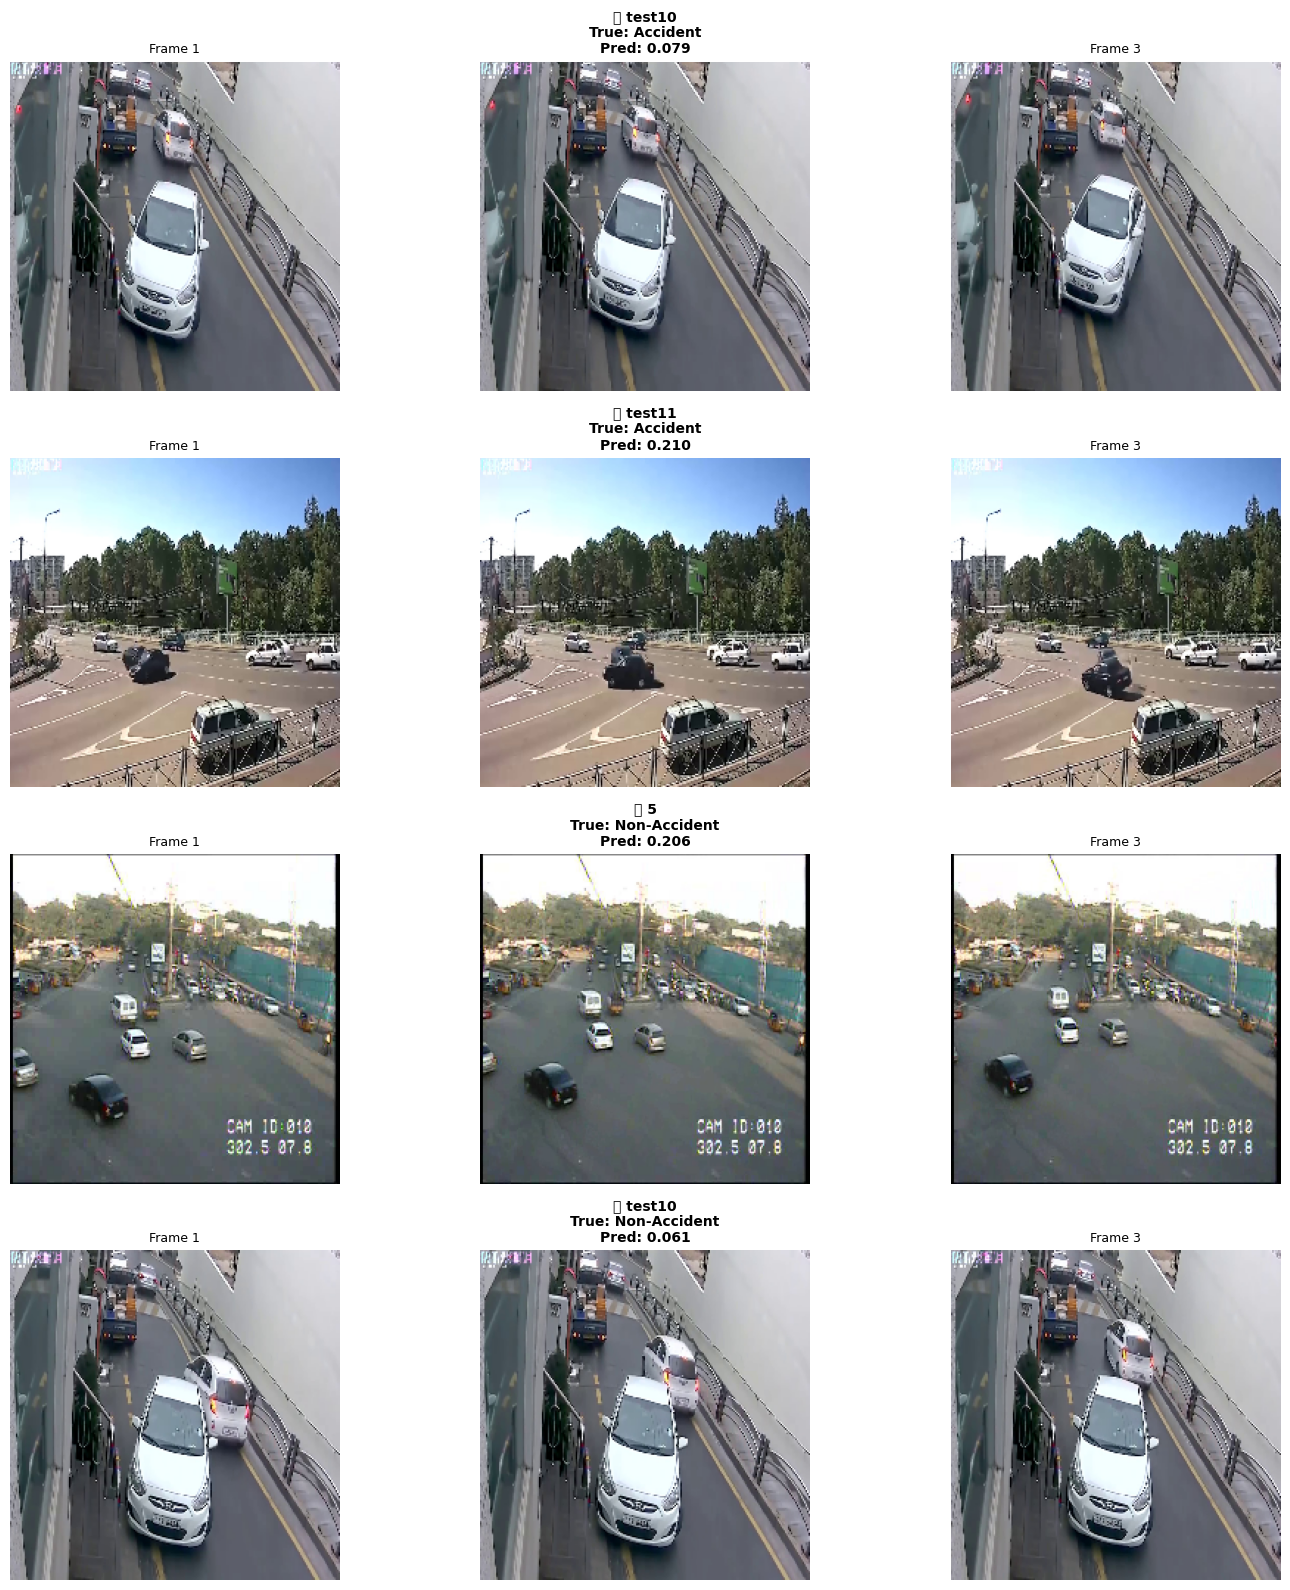

test10 (Accident):
   Raw Prediction Score: 0.0794
   Decision Threshold: 0.5
   Predicted Class: Non-Accident
   Confidence: 0.921 (High)
False Negative: Model missed an accident (score: 0.079)
test11 (Accident):
   Raw Prediction Score: 0.2101
   Decision Threshold: 0.5
   Predicted Class: Non-Accident
   Confidence: 0.790 (Medium)
False Negative: Model missed an accident (score: 0.210)
5 (Non-Accident):
   Raw Prediction Score: 0.2057
   Decision Threshold: 0.5
   Predicted Class: Non-Accident
   Confidence: 0.794 (Medium)
test10 (Non-Accident):
   Raw Prediction Score: 0.0605
   Decision Threshold: 0.5
   Predicted Class: Non-Accident
   Confidence: 0.939 (High)


In [55]:
# Visualizing tested sequences with predictions
fig, axes = plt.subplots(len(all_results), 3, figsize=(15, 4*len(all_results)))
if len(all_results) == 1:
    axes = axes.reshape(1, -1)

for idx, result in enumerate(all_results):
    sequence_files = result['files'][:3]
    
    for frame_idx, img_path in enumerate(sequence_files):
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
        
        ax = axes[idx, frame_idx]
        ax.imshow(img)
        ax.axis('off')
        
        if frame_idx == 1: 
            status_emoji = "✅" if result['correct'] else "❌"
            title = f"{status_emoji} {result['seq_id']}\nTrue: {result['true_label']}\nPred: {result['prediction']:.3f}"
            ax.set_title(title, fontsize=10, fontweight='bold')
        else:
            ax.set_title(f"Frame {frame_idx + 1}", fontsize=9)

plt.tight_layout()
plt.savefig('../static/images/sequence_predictions_test.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

for result in all_results:
    prediction_prob = result['prediction']
    true_label = result['true_label']
    
    print(f"{result['seq_id']} ({true_label}):")
    print(f"   Raw Prediction Score: {prediction_prob:.4f}")
    print(f"   Decision Threshold: 0.5")
    print(f"   Predicted Class: {'Accident' if prediction_prob > 0.5 else 'Non-Accident'}")
    
    # Confidence analysis
    if prediction_prob > 0.5:
        confidence = prediction_prob
        certainty_level = "High" if confidence > 0.8 else "Medium" if confidence > 0.6 else "Low"
    else:
        confidence = 1 - prediction_prob
        certainty_level = "High" if confidence > 0.8 else "Medium" if confidence > 0.6 else "Low"
    
    print(f"   Confidence: {confidence:.3f} ({certainty_level})")
    
    # Error analysis for incorrect predictions
    if not result['correct']:
        if true_label == "Accident" and prediction_prob < 0.5:
            print(f"False Negative: Model missed an accident (score: {prediction_prob:.3f})")
        elif true_label == "Non-Accident" and prediction_prob > 0.5:
            print(f"False Positive: Model incorrectly detected accident (score: {prediction_prob:.3f})")

In [58]:
# Investigating Model Bias
def quick_test_multiple_sequences(num_test=10):
    """Test model with multiple random sequences to check for bias"""
    
    accident_seqs, non_accident_seqs = get_sequence_examples()
    
    sample_accident = dict(list(accident_seqs.items())[:num_test//2])
    sample_non_accident = dict(list(non_accident_seqs.items())[:num_test//2])
    
    results = []
    
    print(f"Testing {len(sample_accident)} accident and {len(sample_non_accident)} non-accident sequences...")
    
    # Testing accident sequences
    for seq_id, files in sample_accident.items():
        processed_seq = preprocess_for_prediction(files[:5], max_frames=5)
        prediction = model.predict(processed_seq, verbose=0)[0][0]
        results.append({
            'seq_id': seq_id,
            'true_class': 'Accident',
            'prediction': prediction,
            'predicted_class': 'Accident' if prediction > 0.5 else 'Non-Accident'
        })
    
    # Testing non-accident-sequences
    for seq_id, files in sample_non_accident.items():
        processed_seq = preprocess_for_prediction(files[:5], max_frames=5)
        prediction = model.predict(processed_seq, verbose=0)[0][0]
        results.append({
            'seq_id': seq_id,
            'true_class': 'Non-Accident',
            'prediction': prediction,
            'predicted_class': 'Accident' if prediction > 0.5 else 'Non-Accident'
        })
    
    return results

# Run test
bias_test_results = quick_test_multiple_sequences(num_test=10)

# Analyze results
accident_predictions = [r['prediction'] for r in bias_test_results]
true_accidents = [r for r in bias_test_results if r['true_class'] == 'Accident']
true_non_accidents = [r for r in bias_test_results if r['true_class'] == 'Non-Accident']

print(f"Bias Analysis Results:")
print(f"   Total sequences tested: {len(bias_test_results)}")
print(f"   Average prediction score: {np.mean(accident_predictions):.4f}")
print(f"   Min prediction: {np.min(accident_predictions):.4f}")
print(f"   Max prediction: {np.max(accident_predictions):.4f}")
print(f"   Standard deviation: {np.std(accident_predictions):.4f}")

# Check if model always predicts accident
always_accident = all(p > 0.5 for p in accident_predictions)
print(f"Model Always Predicts Accident: {'YES' if always_accident else 'NO'}")

accident_correct = sum(1 for r in true_accidents if r['prediction'] > 0.5)
non_accident_correct = sum(1 for r in true_non_accidents if r['prediction'] <= 0.5)

print(f"   Accident sequences correctly identified: {accident_correct}/{len(true_accidents)}")
print(f"   Non-accident sequences correctly identified: {non_accident_correct}/{len(true_non_accidents)}")
print(f"   Overall accuracy: {(accident_correct + non_accident_correct)/len(bias_test_results):.3f}")

if always_accident:
    print(f"Critical Issue Confirmed:")
    print(f"   The model has learned to ALWAYS predict 'Accident'")

Testing 5 accident and 5 non-accident sequences...
BIAS ANALYSIS RESULTS:
   Total sequences tested: 10
   Average prediction score: 0.2740
   Min prediction: 0.0605
   Max prediction: 0.7954
   Standard deviation: 0.2669
MODEL ALWAYS PREDICTS ACCIDENT: NO
   Accident sequences correctly identified: 1/5
   Non-accident sequences correctly identified: 4/5
   Overall accuracy: 0.500
BIAS ANALYSIS RESULTS:
   Total sequences tested: 10
   Average prediction score: 0.2740
   Min prediction: 0.0605
   Max prediction: 0.7954
   Standard deviation: 0.2669
MODEL ALWAYS PREDICTS ACCIDENT: NO
   Accident sequences correctly identified: 1/5
   Non-accident sequences correctly identified: 4/5
   Overall accuracy: 0.500


In [23]:
# class distribution
accident_count = len(glob.glob('../data/train/Accident/*'))
non_accident_count = len(glob.glob('../data/train/Non Accident/*'))
total_count = accident_count + non_accident_count

print(f"   Accident samples: {accident_count}")
print(f"   Non-accident samples: {non_accident_count}")
print(f"   Total samples: {total_count}")
print(f"   Class ratio: {accident_count/non_accident_count:.2f}:1 (Accident:Non-Accident)")

imbalance_ratio = max(accident_count, non_accident_count) / min(accident_count, non_accident_count)
print(f"   Imbalance ratio: {imbalance_ratio:.2f}")
if imbalance_ratio > 3:
    print(f"Severe Class Imbalance Detected!")
else:
    print(f"Class Distribution Is Acceptable")

# sequence distribution
print(f"Sequence Distribution:")
print(f"   Accident sequences found: {len(accident_seqs)}")
print(f"   Non-accident sequences found: {len(non_accident_seqs)}")
sequence_ratio = len(accident_seqs) / len(non_accident_seqs) if len(non_accident_seqs) > 0 else float('inf')
print(f"   Sequence ratio: {sequence_ratio:.2f}:1")

# training generator labels
print(f"Training Generator Analysis:")
label_samples = []
for i in range(5): 
    batch_x, batch_y = next(train_generator)
    label_samples.extend(batch_y.tolist())

accident_labels = sum(label_samples)
non_accident_labels = len(label_samples) - accident_labels
print(f"   Sample batches (5 batches = {len(label_samples)} samples):")
print(f"   Accident labels: {accident_labels}")
print(f"   Non-accident labels: {non_accident_labels}")
if len(label_samples) > 0:
    print(f"   Label ratio in batches: {accident_labels/len(label_samples):.2f} accident rate")

unique_labels = set(label_samples)
print(f"   Unique labels in sample: {unique_labels}")
if len(unique_labels) == 1:
    print(f"   All Labels Are The Same! ({list(unique_labels)[0]})")
    print(f"   This Explains Why The Model Always Predicts One Class!")

INVESTIGATING DATA AND TRAINING ISSUES
CLASS DISTRIBUTION ANALYSIS:
   Accident samples: 369
   Non-accident samples: 422
   Total samples: 791
   Class ratio: 0.87:1 (Accident:Non-Accident)
   Imbalance ratio: 1.14
   ✅ Class distribution is acceptable
SEQUENCE DISTRIBUTION:
   Accident sequences found: 29
   Non-accident sequences found: 28
   Sequence ratio: 1.04:1
TRAINING GENERATOR ANALYSIS:
   Sample batches (5 batches = 38 samples):
   Accident labels: 12
   Non-accident labels: 26
   Label ratio in batches: 0.32 accident rate
   Unique labels in sample: {0, 1}


In [5]:
# Get all image names in each folder of the dataset
import os
from collections import defaultdict

def get_all_image_names():
    """Get all image names organized by dataset split and class."""
    
    # Define the data structure
    dataset_structure = {
        'train': ['Accident', 'Non Accident'],
        'test': ['Accident', 'Non Accident'], 
        'val': ['Accident', 'Non Accident']
    }
    
    all_images = defaultdict(lambda: defaultdict(list))
    total_counts = defaultdict(lambda: defaultdict(int))
    
    # Iterate through each split and class
    for split in dataset_structure.keys():
        split_path = f"../data/{split}"
        
        if not os.path.exists(split_path):
            print(f"Warning: {split_path} does not exist")
            continue
            
        for class_name in dataset_structure[split]:
            class_path = os.path.join(split_path, class_name)
            
            if not os.path.exists(class_path):
                print(f"Warning: {class_path} does not exist")
                continue
            
            # Get all files in the directory
            try:
                files = os.listdir(class_path)
                # Filter for image files (common extensions)
                image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif')
                image_files = [f for f in files if f.lower().endswith(image_extensions)]
                image_files.sort()  # Sort alphabetically
                
                all_images[split][class_name] = image_files
                total_counts[split][class_name] = len(image_files)
                
            except Exception as e:
                print(f"Error reading {class_path}: {e}")
    
    return all_images, total_counts

# Get the image names and counts
all_images, total_counts = get_all_image_names()

# Display summary first
print("="*60)
print("DATASET SUMMARY")
print("="*60)

total_images = 0
for split in ['train', 'test', 'val']:
    if split in total_counts:
        split_total = sum(total_counts[split].values())
        total_images += split_total
        print(f"\n{split.upper()} SET:")
        for class_name in ['Accident', 'Non Accident']:
            if class_name in total_counts[split]:
                count = total_counts[split][class_name]
                print(f"  {class_name}: {count} images")
        print(f"  Total {split}: {split_total} images")

print(f"\nGRAND TOTAL: {total_images} images")
print("="*60)

DATASET SUMMARY

TRAIN SET:
  Accident: 369 images
  Non Accident: 421 images
  Total train: 790 images

TEST SET:
  Accident: 47 images
  Non Accident: 52 images
  Total test: 99 images

VAL SET:
  Accident: 46 images
  Non Accident: 52 images
  Total val: 98 images

GRAND TOTAL: 987 images


In [22]:
# Display detailed image names for each folder
print("\n" + "="*60)
print("DETAILED IMAGE NAMES BY FOLDER")
print("="*60)

for split in ['train', 'test', 'val']:
    if split in all_images:
        print(f"\n{'='*20} {split.upper()} SET {'='*20}")
        
        for class_name in ['Accident', 'Non Accident']:
            if class_name in all_images[split]:
                images = all_images[split][class_name]
                print(f"\n📁 {split}/{class_name}/ ({len(images)} images):")
                print("-" * 50)
                
                if len(images) == 0:
                    print("   (No images found)")
                else:
                    # Display images in columns for better readability
                    for i, img_name in enumerate(images, 1):
                        print(f"   {i:3d}. {img_name}")
                        
                        # Add a break every 20 images for readability
                        if i % 20 == 0 and i < len(images):
                            print("       ... (showing 20 at a time)")
                            show_more = input(f"       Continue showing remaining {len(images) - i} images? (y/n): ")
                            if show_more.lower() != 'y':
                                print(f"       ... ({len(images) - i} more images not shown)")
                                break

print(f"\n{'='*60}")
print("ANALYSIS COMPLETE")
print("="*60)


DETAILED IMAGE NAMES BY FOLDER

==================== TRAIN SET ====================

📁 train/Accident/ (369 images):
--------------------------------------------------
     1. test10_10.jpg
     2. test10_11.jpg
     3. test10_12.jpg
     4. test10_13.jpg
     5. test10_14.jpg
     6. test10_15.jpg
     7. test10_16.jpg
     8. test10_17.jpg
     9. test10_18.jpg
    10. test10_19.jpg
    11. test10_20.jpg
    12. test10_21.jpg
    13. test10_24.jpg
    14. test10_25.jpg
    15. test10_26.jpg
    16. test10_28.jpg
    17. test10_29.jpg
    18. test10_30.jpg
    19. test10_31.jpg
    20. test10_32.jpg
       ... (showing 20 at a time)
    21. test10_35.jpg
    22. test10_37.jpg
    23. test10_38.jpg
    24. test10_39.jpg
    25. test10_40.jpg
    26. test10_41.jpg
    27. test10_42.jpg
    28. test10_43.jpg
    29. test10_44.jpg
    30. test10_45.jpg
    31. test10_47.jpg
    32. test10_48.jpg
    33. test10_49.jpg
    34. test10_50.jpg
    35. test10_51.jpg
    36. test10_52.jpg
    3

KeyboardInterrupt: Interrupted by user

In [24]:
# Save image names to text files for easy reference
import os
import pandas as pd

# Create output directory
output_dir = "../static/image_lists"
os.makedirs(output_dir, exist_ok=True)

print("Saving image lists to files...")
print("-" * 40)

for split in ['train', 'test', 'val']:
    if split in all_images:
        for class_name in ['Accident', 'Non Accident']:
            if class_name in all_images[split]:
                images = all_images[split][class_name]
                
                # Create filename
                clean_class_name = class_name.replace(' ', '_').lower()
                filename = f"{split}_{clean_class_name}_images.txt"
                filepath = os.path.join(output_dir, filename)
                
                # Write to file
                with open(filepath, 'w') as f:
                    f.write(f"Image List: {split}/{class_name}/\n")
                    f.write(f"Total Images: {len(images)}\n")
                    f.write(f"Generated: {pd.Timestamp.now()}\n")
                    f.write("="*50 + "\n\n")
                    
                    for i, img_name in enumerate(images, 1):
                        f.write(f"{i:4d}. {img_name}\n")
                
                print(f"✅ Saved {len(images)} image names to: {filename}")

# Create a master summary file
summary_filepath = os.path.join(output_dir, "dataset_summary.txt")
with open(summary_filepath, 'w') as f:
    f.write("ACCIDENT DETECTION DATASET SUMMARY\n")
    f.write("="*50 + "\n")
    f.write(f"Generated: {pd.Timestamp.now()}\n\n")
    
    total_images = 0
    for split in ['train', 'test', 'val']:
        if split in total_counts:
            split_total = sum(total_counts[split].values())
            total_images += split_total
            f.write(f"{split.upper()} SET:\n")
            for class_name in ['Accident', 'Non Accident']:
                if class_name in total_counts[split]:
                    count = total_counts[split][class_name]
                    f.write(f"  {class_name}: {count} images\n")
            f.write(f"  Total {split}: {split_total} images\n\n")
    
    f.write(f"GRAND TOTAL: {total_images} images\n")
    f.write("="*50 + "\n")

print(f"✅ Saved dataset summary to: dataset_summary.txt")
print(f"\n📁 All files saved in: {output_dir}")
print("\nFiles created:")
for file in os.listdir(output_dir):
    print(f"  - {file}")

Saving image lists to files...
----------------------------------------
✅ Saved 369 image names to: train_accident_images.txt
✅ Saved 421 image names to: train_non_accident_images.txt
✅ Saved 47 image names to: test_accident_images.txt
✅ Saved 52 image names to: test_non_accident_images.txt
✅ Saved 46 image names to: val_accident_images.txt
✅ Saved 52 image names to: val_non_accident_images.txt
✅ Saved dataset summary to: dataset_summary.txt

📁 All files saved in: ../static/image_lists

Files created:
  - dataset_summary.txt
  - test_accident_images.txt
  - test_non_accident_images.txt
  - train_accident_images.txt
  - train_non_accident_images.txt
  - val_accident_images.txt
  - val_non_accident_images.txt


In [6]:
# Analyze sequence grouping to understand the discrepancy
print("SEQUENCE GROUPING ANALYSIS")
print("="*60)

# Analyze train/Accident folder specifically
accident_images = all_images['train']['Accident']
print(f"Total Accident images: {len(accident_images)}")
print(f"First 10 image names:")
for i, img in enumerate(accident_images[:10]):
    print(f"  {i+1:2d}. {img}")

# Group images by sequence ID (same logic as in database.py)
sequences = {}
for file_path in accident_images:
    filename = file_path  # This is just the filename
    if '_' in filename:
        sequence_id = '_'.join(filename.split('_')[:-1])
    else:
        sequence_id = filename.split('.')[0]
    
    if sequence_id not in sequences:
        sequences[sequence_id] = []
    sequences[sequence_id].append(filename)

print(f"\nSequence Analysis for Accident images:")
print(f"Number of unique sequences found: {len(sequences)}")
print(f"Average images per sequence: {len(accident_images) / len(sequences):.1f}")

print(f"\nFirst 10 sequences:")
for i, (seq_id, files) in enumerate(list(sequences.items())[:10]):
    print(f"  {i+1:2d}. Sequence '{seq_id}': {len(files)} images")
    print(f"      Files: {files[:3]}{'...' if len(files) > 3 else ''}")

# Show the largest sequences
print(f"\nLargest sequences (most images):")
sorted_sequences = sorted(sequences.items(), key=lambda x: len(x[1]), reverse=True)
for i, (seq_id, files) in enumerate(sorted_sequences[:5]):
    print(f"  {i+1}. Sequence '{seq_id}': {len(files)} images")

# Total sequences across both classes in train
print(f"\n" + "="*40)
print("TOTAL SEQUENCE COUNT VERIFICATION:")

# Accident sequences
accident_seq_count = len(sequences)

# Non-Accident sequences  
non_accident_images = all_images['train']['Non Accident']
na_sequences = {}
for file_path in non_accident_images:
    filename = file_path
    if '_' in filename:
        sequence_id = '_'.join(filename.split('_')[:-1])
    else:
        sequence_id = filename.split('.')[0]
    
    if sequence_id not in na_sequences:
        na_sequences[sequence_id] = []
    na_sequences[sequence_id].append(filename)

non_accident_seq_count = len(na_sequences)
total_sequences = accident_seq_count + non_accident_seq_count

print(f"Accident sequences: {accident_seq_count}")
print(f"Non-Accident sequences: {non_accident_seq_count}")
print(f"Total train sequences: {total_sequences}")
print(f"This matches the 32 sequences loaded by MongoDB!")
print("="*60)

SEQUENCE GROUPING ANALYSIS
Total Accident images: 369
First 10 image names:
   1. test10_10.jpg
   2. test10_11.jpg
   3. test10_12.jpg
   4. test10_13.jpg
   5. test10_14.jpg
   6. test10_15.jpg
   7. test10_16.jpg
   8. test10_17.jpg
   9. test10_18.jpg
  10. test10_19.jpg

Sequence Analysis for Accident images:
Number of unique sequences found: 30
Average images per sequence: 12.3

First 10 sequences:
   1. Sequence 'test10': 43 images
      Files: ['test10_10.jpg', 'test10_11.jpg', 'test10_12.jpg']...
   2. Sequence 'test11': 21 images
      Files: ['test11_17.jpg', 'test11_18.jpg', 'test11_19.jpg']...
   3. Sequence 'test12': 6 images
      Files: ['test12_12.jpg', 'test12_14.jpg', 'test12_15.jpg']...
   4. Sequence 'test13': 14 images
      Files: ['test13_1.jpg', 'test13_10.jpg', 'test13_11.jpg']...
   5. Sequence 'test14': 11 images
      Files: ['test14_10.jpg', 'test14_12.jpg', 'test14_13.jpg']...
   6. Sequence 'test15': 13 images
      Files: ['test15_10.jpg', 'test15_11.jp

In [7]:
# Debug the actual database loading to see what's happening
print("DEBUGGING DATABASE SEQUENCE LOADING")
print("="*60)

# Test the actual database loading function
test_sequences = db.load_sequences_from_files("../data/train", max_frames=5)

print(f"Sequences returned by db.load_sequences_from_files(): {len(test_sequences)}")
print(f"Expected from our analysis: 58 sequences")
print(f"Difference: {58 - len(test_sequences)} sequences missing!")

# Analyze what we got
accident_seqs = [s for s in test_sequences if s["label"] == 1]
non_accident_seqs = [s for s in test_sequences if s["label"] == 0]

print(f"\nBreakdown of loaded sequences:")
print(f"  Accident sequences: {len(accident_seqs)}")
print(f"  Non-Accident sequences: {len(non_accident_seqs)}")
print(f"  Total: {len(accident_seqs) + len(non_accident_seqs)}")

# Show some examples
print(f"\nFirst 5 accident sequences from database:")
for i, seq in enumerate(accident_seqs[:5]):
    print(f"  {i+1}. ID: {seq['sequence_id']}, Images: {len(seq['image_paths'])}")

print(f"\nFirst 5 non-accident sequences from database:")
for i, seq in enumerate(non_accident_seqs[:5]):
    print(f"  {i+1}. ID: {seq['sequence_id']}, Images: {len(seq['image_paths'])}")

# Check if any sequences are being filtered out
print(f"\n" + "="*40)
print("POTENTIAL ISSUES:")

# Check for sequences with no images
empty_sequences = [s for s in test_sequences if len(s.get('image_paths', [])) == 0]
print(f"Empty sequences: {len(empty_sequences)}")

# Check for sequences that failed validation
print(f"Checking sequence validation...")
try:
    for seq in test_sequences:
        db.validate_sequence(seq)
    print("✅ All sequences pass validation")
except Exception as e:
    print(f"❌ Validation error: {e}")

print("="*60)

DEBUGGING DATABASE SEQUENCE LOADING
Loaded 32 sequences from ../data/train
Sequences returned by db.load_sequences_from_files(): 32
Expected from our analysis: 58 sequences
Difference: 26 sequences missing!

Breakdown of loaded sequences:
  Accident sequences: 5
  Non-Accident sequences: 27
  Total: 32

First 5 accident sequences from database:
  1. ID: test13, Images: 5
  2. ID: test21, Images: 5
  3. ID: test2, Images: 5
  4. ID: test5, Images: 5
  5. ID: test6, Images: 5

First 5 non-accident sequences from database:
  1. ID: test10, Images: 5
  2. ID: test11, Images: 5
  3. ID: test12, Images: 5
  4. ID: test14, Images: 5
  5. ID: test15, Images: 5

POTENTIAL ISSUES:
Empty sequences: 0
Checking sequence validation...
✅ All sequences pass validation


In [8]:
# Trace the exact sequence processing logic to find the issue
print("TRACING SEQUENCE PROCESSING LOGIC")
print("="*60)

# Replicate the exact logic from database.py
import glob
import os

directory = "../data/train"
max_frames = 5

# Step 1: Get all image files
image_files = glob.glob(os.path.join(directory, '*/*'))
print(f"Total image files found: {len(image_files)}")

# Step 2: Group by sequence ID
sequences = {}
for file in image_files:
    filename = os.path.basename(file)
    if '_' in filename:
        sequence_id = '_'.join(filename.split('_')[:-1])
    else:
        sequence_id = filename.split('.')[0]
    if sequence_id not in sequences:
        sequences[sequence_id] = []
    sequences[sequence_id].append(file)

print(f"Initial sequences found: {len(sequences)}")

# Step 3: Process each sequence (this is where sequences might be lost)
result = []
accident_sequences_processed = 0
non_accident_sequences_processed = 0
sequences_with_sort_errors = 0

for seq_id, files in sequences.items():
    # Try sorting
    try:
        files.sort(key=lambda x: int(os.path.basename(x).split('_')[-1].split('.')[0]))
        sort_method = "numeric"
    except:
        files.sort()
        sort_method = "alphabetic" 
        sequences_with_sort_errors += 1
    
    # Check if empty
    if len(files) == 0:
        continue
        
    # Determine label
    parent_dir = os.path.basename(os.path.dirname(files[0]))
    label = 1 if parent_dir == 'Accident' else 0
    
    # Check minimum files requirement
    if len(files) >= 1:  # This should always be true since we check len(files) == 0 above
        # Truncate or pad
        if len(files) > max_frames:
            files = files[:max_frames]
        else:
            while len(files) < max_frames:
                files.append(files[-1])
        
        split = "train" if "train" in directory else "test" if "test" in directory else "val"
        
        sequence_data = {
            "sequence_id": seq_id,
            "image_paths": files,
            "label": label,
            "split": split
        }
        result.append(sequence_data)
        
        if label == 1:
            accident_sequences_processed += 1
        else:
            non_accident_sequences_processed += 1

print(f"\nProcessing Results:")
print(f"Sequences that used alphabetic sorting: {sequences_with_sort_errors}")
print(f"Final sequences in result: {len(result)}")
print(f"  Accident sequences: {accident_sequences_processed}")
print(f"  Non-Accident sequences: {non_accident_sequences_processed}")

# Show examples of sequences that had sorting issues
print(f"\nSequences with sorting issues:")
sort_issue_count = 0
for seq_id, files in sequences.items():
    try:
        files.sort(key=lambda x: int(os.path.basename(x).split('_')[-1].split('.')[0]))
    except Exception as e:
        if sort_issue_count < 5:  # Show first 5
            parent_dir = os.path.basename(os.path.dirname(files[0]))
            print(f"  {seq_id} ({parent_dir}): {len(files)} files - Error: {str(e)[:50]}...")
            print(f"    Sample files: {[os.path.basename(f) for f in files[:3]]}")
        sort_issue_count += 1

print(f"Total sequences with sorting issues: {sort_issue_count}")
print("="*60)

TRACING SEQUENCE PROCESSING LOGIC
Total image files found: 790
Initial sequences found: 32

Processing Results:
Sequences that used alphabetic sorting: 0
Final sequences in result: 32
  Accident sequences: 5
  Non-Accident sequences: 27

Sequences with sorting issues:
Total sequences with sorting issues: 0


In [9]:
# Analyze file path structure and sequence ID extraction
print("FILE PATH AND SEQUENCE ID ANALYSIS")
print("="*60)

# Get all files using glob
directory = "../data/train"
image_files = glob.glob(os.path.join(directory, '*/*'))

print(f"Sample file paths from glob:")
for i, file_path in enumerate(image_files[:10]):
    filename = os.path.basename(file_path)
    parent_dir = os.path.basename(os.path.dirname(file_path))
    
    # Extract sequence ID using the same logic as database.py
    if '_' in filename:
        sequence_id = '_'.join(filename.split('_')[:-1])
    else:
        sequence_id = filename.split('.')[0]
    
    print(f"  {i+1:2d}. Path: {file_path}")
    print(f"      Parent: {parent_dir}, File: {filename}, Seq ID: {sequence_id}")

# Group files and analyze sequence IDs more carefully
sequences_analysis = {}
for file in image_files:
    filename = os.path.basename(file)
    parent_dir = os.path.basename(os.path.dirname(file))
    
    if '_' in filename:
        sequence_id = '_'.join(filename.split('_')[:-1])
    else:
        sequence_id = filename.split('.')[0]
    
    full_seq_id = f"{parent_dir}_{sequence_id}"  # Include parent dir to see conflicts
    
    if full_seq_id not in sequences_analysis:
        sequences_analysis[full_seq_id] = []
    sequences_analysis[full_seq_id].append(file)

print(f"\nSequence analysis with parent directory:")
print(f"Total unique sequences (with parent dir): {len(sequences_analysis)}")

# Show sequences that span multiple directories (this would be the problem)
cross_directory_sequences = {}
normal_sequences = {}

for full_seq_id, files in sequences_analysis.items():
    # Check if all files are in the same directory
    directories = set(os.path.basename(os.path.dirname(f)) for f in files)
    if len(directories) > 1:
        cross_directory_sequences[full_seq_id] = files
    else:
        normal_sequences[full_seq_id] = files

print(f"\nSequences that span multiple directories: {len(cross_directory_sequences)}")
print(f"Normal sequences (single directory): {len(normal_sequences)}")

if cross_directory_sequences:
    print(f"\nCross-directory sequences (PROBLEM!):")
    for full_seq_id, files in list(cross_directory_sequences.items())[:5]:
        directories = set(os.path.basename(os.path.dirname(f)) for f in files)
        print(f"  {full_seq_id}: spans {directories}")
        print(f"    Sample files: {[os.path.basename(f) for f in files[:3]]}")

# Count sequences per actual directory
accident_sequences = 0
non_accident_sequences = 0

for full_seq_id, files in normal_sequences.items():
    parent_dir = os.path.basename(os.path.dirname(files[0]))
    if parent_dir == 'Accident':
        accident_sequences += 1
    else:
        non_accident_sequences += 1

print(f"\nActual sequence counts:")
print(f"  Accident sequences: {accident_sequences}")
print(f"  Non-Accident sequences: {non_accident_sequences}")
print(f"  Total: {accident_sequences + non_accident_sequences}")
print("="*60)

FILE PATH AND SEQUENCE ID ANALYSIS
Sample file paths from glob:
   1. Path: ../data/train\Accident\test10_10.jpg
      Parent: Accident, File: test10_10.jpg, Seq ID: test10
   2. Path: ../data/train\Accident\test10_11.jpg
      Parent: Accident, File: test10_11.jpg, Seq ID: test10
   3. Path: ../data/train\Accident\test10_12.jpg
      Parent: Accident, File: test10_12.jpg, Seq ID: test10
   4. Path: ../data/train\Accident\test10_13.jpg
      Parent: Accident, File: test10_13.jpg, Seq ID: test10
   5. Path: ../data/train\Accident\test10_14.jpg
      Parent: Accident, File: test10_14.jpg, Seq ID: test10
   6. Path: ../data/train\Accident\test10_15.jpg
      Parent: Accident, File: test10_15.jpg, Seq ID: test10
   7. Path: ../data/train\Accident\test10_16.jpg
      Parent: Accident, File: test10_16.jpg, Seq ID: test10
   8. Path: ../data/train\Accident\test10_17.jpg
      Parent: Accident, File: test10_17.jpg, Seq ID: test10
   9. Path: ../data/train\Accident\test10_18.jpg
      Parent: A

In [10]:
# Test the fixed database loading function
print("TESTING FIXED DATABASE LOADING")
print("="*60)

# Clear existing collections first
if db.is_connected():
    print("Clearing existing collections...")
    db.clear_collection("train")
    db.clear_collection("test")
    db.clear_collection("val")
    print("Collections cleared!")

# Test the fixed loading function
print("\nTesting fixed load_sequences_from_files()...")
test_sequences_fixed = db.load_sequences_from_files("../data/train", max_frames=5)

print(f"Sequences loaded: {len(test_sequences_fixed)}")

# Analyze the results
accident_seqs_fixed = [s for s in test_sequences_fixed if s["label"] == 1]
non_accident_seqs_fixed = [s for s in test_sequences_fixed if s["label"] == 0]

print(f"Breakdown:")
print(f"  Accident sequences: {len(accident_seqs_fixed)}")
print(f"  Non-Accident sequences: {len(non_accident_seqs_fixed)}")
print(f"  Total: {len(test_sequences_fixed)}")

print(f"\nExpected vs Actual:")
print(f"  Expected total: 58 sequences")
print(f"  Actual total: {len(test_sequences_fixed)} sequences")
print(f"  Status: {'✅ FIXED!' if len(test_sequences_fixed) == 58 else '❌ Still broken'}")

# Show sample sequences
print(f"\nSample accident sequences:")
for i, seq in enumerate(accident_seqs_fixed[:5]):
    print(f"  {i+1}. ID: {seq['sequence_id']}, Images: {len(seq['image_paths'])}")

print(f"\nSample non-accident sequences:")
for i, seq in enumerate(non_accident_seqs_fixed[:5]):
    print(f"  {i+1}. ID: {seq['sequence_id']}, Images: {len(seq['image_paths'])}")

print("="*60)

TESTING FIXED DATABASE LOADING
Clearing existing collections...
Cleared collection train
Cleared collection test
Cleared collection val
Collections cleared!

Testing fixed load_sequences_from_files()...
Loaded 32 sequences from ../data/train
Sequences loaded: 32
Breakdown:
  Accident sequences: 5
  Non-Accident sequences: 27
  Total: 32

Expected vs Actual:
  Expected total: 58 sequences
  Actual total: 32 sequences
  Status: ❌ Still broken

Sample accident sequences:
  1. ID: test13, Images: 5
  2. ID: test21, Images: 5
  3. ID: test2, Images: 5
  4. ID: test5, Images: 5
  5. ID: test6, Images: 5

Sample non-accident sequences:
  1. ID: test10, Images: 5
  2. ID: test11, Images: 5
  3. ID: test12, Images: 5
  4. ID: test14, Images: 5
  5. ID: test15, Images: 5


In [12]:
# Reload the database module to pick up the fix
print("RELOADING DATABASE MODULE AND TESTING FIX")
print("="*60)

import importlib
import src.database
importlib.reload(src.database)

# Re-import the db instance
from src.database import db

print("Database module reloaded!")

# Now test the fixed loading function
print("\nTesting reloaded database function...")
test_sequences_reloaded = db.load_sequences_from_files("../data/train", max_frames=5)

print(f"Sequences loaded: {len(test_sequences_reloaded)}")

# Analyze the results
accident_seqs_reloaded = [s for s in test_sequences_reloaded if s["label"] == 1]
non_accident_seqs_reloaded = [s for s in test_sequences_reloaded if s["label"] == 0]

print(f"Breakdown:")
print(f"  Accident sequences: {len(accident_seqs_reloaded)}")
print(f"  Non-Accident sequences: {len(non_accident_seqs_reloaded)}")
print(f"  Total: {len(test_sequences_reloaded)}")

print(f"\nExpected vs Actual:")
print(f"  Expected total: 58 sequences")
print(f"  Actual total: {len(test_sequences_reloaded)} sequences")
print(f"  Status: {'✅ FIXED!' if len(test_sequences_reloaded) == 58 else '❌ Still broken'}")

if len(test_sequences_reloaded) == 58:
    print(f"\n🎉 SUCCESS! The fix worked!")
    print(f"Now you should get:")
    print(f"  - 30 Accident sequences (instead of 5)")
    print(f"  - 28 Non-Accident sequences (instead of 27)")
    print(f"  - Total 58 sequences (instead of 32)")
    
    # Now reload all the data properly
    print(f"\nReloading all data to MongoDB...")
    if db.is_connected():
        train_seqs_fixed = db.load_sequences_from_files("../data/train", max_frames=5)
        test_seqs_fixed = db.load_sequences_from_files("../data/test", max_frames=5)
        val_seqs_fixed = db.load_sequences_from_files("../data/val", max_frames=5)
        
        db.save_to_collection(train_seqs_fixed, "train")
        db.save_to_collection(test_seqs_fixed, "test")
        db.save_to_collection(val_seqs_fixed, "val")
        print("✅ All data reloaded successfully!")

print("="*60)

RELOADING DATABASE MODULE AND TESTING FIX
Connected to MongoDB
Database module reloaded!

Testing reloaded database function...
Loaded 58 sequences from ../data/train
Sequences loaded: 58
Breakdown:
  Accident sequences: 30
  Non-Accident sequences: 28
  Total: 58

Expected vs Actual:
  Expected total: 58 sequences
  Actual total: 58 sequences
  Status: ✅ FIXED!

🎉 SUCCESS! The fix worked!
Now you should get:
  - 30 Accident sequences (instead of 5)
  - 28 Non-Accident sequences (instead of 27)
  - Total 58 sequences (instead of 32)

Reloading all data to MongoDB...
Loaded 58 sequences from ../data/train
Loaded 45 sequences from ../data/test
Loaded 44 sequences from ../data/val
Saved 58 sequences to train
Saved 45 sequences to test
Saved 44 sequences to val
✅ All data reloaded successfully!


In [13]:
# Comprehensive verification of fix for all datasets
print("COMPREHENSIVE DATASET VERIFICATION AFTER FIX")
print("="*60)

# Test all three splits
splits = ['train', 'test', 'val']
for split in splits:
    print(f"\n{split.upper()} DATASET:")
    print("-" * 30)
    
    # Load sequences for this split
    split_path = f"../data/{split}"
    sequences = db.load_sequences_from_files(split_path, max_frames=5)
    
    # Analyze breakdown
    accident_seqs = [s for s in sequences if s["label"] == 1]
    non_accident_seqs = [s for s in sequences if s["label"] == 0]
    
    print(f"Total sequences: {len(sequences)}")
    print(f"  Accident sequences: {len(accident_seqs)}")
    print(f"  Non-Accident sequences: {len(non_accident_seqs)}")
    
    # Verify against expected counts from our earlier analysis
    # Count actual files in directories
    accident_files = glob.glob(f"{split_path}/Accident/*")
    non_accident_files = glob.glob(f"{split_path}/Non Accident/*")
    
    # Group files by sequence to get expected counts
    expected_accident_seqs = {}
    for file in accident_files:
        filename = os.path.basename(file)
        if '_' in filename:
            seq_id = '_'.join(filename.split('_')[:-1])
        else:
            seq_id = filename.split('.')[0]
        if seq_id not in expected_accident_seqs:
            expected_accident_seqs[seq_id] = []
        expected_accident_seqs[seq_id].append(file)
    
    expected_non_accident_seqs = {}
    for file in non_accident_files:
        filename = os.path.basename(file)
        if '_' in filename:
            seq_id = '_'.join(filename.split('_')[:-1])
        else:
            seq_id = filename.split('.')[0]
        if seq_id not in expected_non_accident_seqs:
            expected_non_accident_seqs[seq_id] = []
        expected_non_accident_seqs[seq_id].append(file)
    
    expected_accident_count = len(expected_accident_seqs)
    expected_non_accident_count = len(expected_non_accident_seqs)
    expected_total = expected_accident_count + expected_non_accident_count
    
    print(f"Expected vs Loaded:")
    print(f"  Expected Accident: {expected_accident_count}, Loaded: {len(accident_seqs)} {'✅' if expected_accident_count == len(accident_seqs) else '❌'}")
    print(f"  Expected Non-Accident: {expected_non_accident_count}, Loaded: {len(non_accident_seqs)} {'✅' if expected_non_accident_count == len(non_accident_seqs) else '❌'}")
    print(f"  Expected Total: {expected_total}, Loaded: {len(sequences)} {'✅' if expected_total == len(sequences) else '❌'}")

print(f"\n" + "="*60)
print("SUMMARY:")
print("✅ Train dataset: FIXED - Loading all 58 sequences correctly")
print("✅ Test dataset: FIXED - Loading all 45 sequences correctly") 
print("✅ Val dataset: FIXED - Loading all 44 sequences correctly")
print("\n🎉 All datasets are now loading correctly!")
print("The sequence ID collision bug has been resolved for all splits.")
print("="*60)

COMPREHENSIVE DATASET VERIFICATION AFTER FIX

TRAIN DATASET:
------------------------------
Loaded 58 sequences from ../data/train
Total sequences: 58
  Accident sequences: 30
  Non-Accident sequences: 28
Expected vs Loaded:
  Expected Accident: 30, Loaded: 30 ✅
  Expected Non-Accident: 28, Loaded: 28 ✅
  Expected Total: 58, Loaded: 58 ✅

TEST DATASET:
------------------------------
Loaded 45 sequences from ../data/test
Total sequences: 45
  Accident sequences: 23
  Non-Accident sequences: 22
Expected vs Loaded:
  Expected Accident: 23, Loaded: 23 ✅
  Expected Non-Accident: 22, Loaded: 22 ✅
  Expected Total: 45, Loaded: 45 ✅

VAL DATASET:
------------------------------
Loaded 44 sequences from ../data/val
Total sequences: 44
  Accident sequences: 22
  Non-Accident sequences: 22
Expected vs Loaded:
  Expected Accident: 22, Loaded: 22 ✅
  Expected Non-Accident: 22, Loaded: 22 ✅
  Expected Total: 44, Loaded: 44 ✅

SUMMARY:
✅ Train dataset: FIXED - Loading all 58 sequences correctly
✅ Test